# 機械学習をPythonで実践する-18　　～ 様々なエンコーディング手法 ～

In [114]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder, OneHotEncoder
# # import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
from sklearn.compose import ColumnTransformer
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from lightGBM_cv import lightGBM_classifier_cv_func
from category_encoders import TargetEncoder


%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Label Encoding
ペンギンデータセットに対してラベルエンコーディングを適用する。  
このデータセットの質的変数は順序尺度ではないので、ラベルエンコーディングは適さないが、  
決定木やGBDTであればラベルエンコーディングで問題ないので、これを想定してやってみる。

In [15]:
# データセットのカラム名やデータ型は分かっているので、dtypesを指定しておく。
dtypes = {
    "species": str,
    'island': str,
    'culmen_length_mm': pl.Float32, # くちばしの長さ[mm]
    'culmen_depth_mm': pl.Float32, # くちばしの高さ[mm]
    'flipper_length_mm': pl.Float32, # 翼の長さ[mm]
    'body_mass_g': pl.Float32, # 体重[g]
    'sex': str
}

# ペンギンのデータセット読み込み。欠損値がNAとして含まれているので、null_values="NA"を指定しないと読み込みエラーになる。
df = pl.read_csv('../Python/sample_data/ML_sample/penguins_size.csv',dtypes=dtypes, null_values='NA')

In [14]:
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.299999,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",null,null,null,null,null
"""Adelie""","""Torgersen""",36.700001,19.299999,193.0,3450.0,"""FEMALE"""


In [7]:
# 量的変数と質的変数のカラム名をそれぞれ取得。今回は目的変数も含めてエンコーディングしちゃう。
num_cols = df.select(pl.col(pl.Float32)).columns
cat_cols = df.select(pl.col(pl.Utf8)).columns

In [17]:
# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
df = df.with_columns( pl.from_pandas(oe.fit_transform(df.select(cat_cols).to_pandas())) )

In [18]:
df

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
f64,f64,f32,f32,f32,f32,f64
0.0,2.0,39.099998,18.700001,181.0,3750.0,2.0
0.0,2.0,39.5,17.4,186.0,3800.0,1.0
0.0,2.0,40.299999,18.0,195.0,3250.0,1.0
0.0,2.0,null,null,null,null,3.0
0.0,2.0,36.700001,19.299999,193.0,3450.0,1.0
0.0,2.0,39.299999,20.6,190.0,3650.0,2.0
0.0,2.0,38.900002,17.799999,181.0,3625.0,1.0
0.0,2.0,39.200001,19.6,195.0,4675.0,2.0
0.0,2.0,34.099998,18.1,193.0,3475.0,3.0


sexカラムにあった欠損値は3.0にラベル付けされた模様。

## Target Encoding

scikit-LearnにはTarget Encoding用のパッケージは入っていないので、  
pip installする必要あり。  

category_encoders.TargetEncoder()クラスを使う。  
使い方はscikit-learnの各クラスと同様。
* インスタンス生成
* .fit(X, y) → TargetEncodingなので、目的変数もfitに渡す必要あり。
* .transform(X)
  * Leakage防止のため、.fitの際にテストデータを含まないように注意。今回の例では全て学習データとして扱う。

In [19]:
%pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### - 二値分類の場合

In [41]:
# データ読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))
df = df.drop_nulls()
df.head()

survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
i64,i64,str,f64,i64,i64,f64,str,cat,str,bool,cat,str,str,bool
1,1,"""female""",38.0,1,0,71.2833,"""C""","""First""","""woman""",false,"""C""","""Cherbourg""","""yes""",false
1,1,"""female""",35.0,1,0,53.1,"""S""","""First""","""woman""",false,"""C""","""Southampton""","""yes""",false
0,1,"""male""",54.0,0,0,51.8625,"""S""","""First""","""man""",true,"""E""","""Southampton""","""no""",true
1,3,"""female""",4.0,1,1,16.7,"""S""","""Third""","""child""",false,"""G""","""Southampton""","""yes""",false
1,1,"""female""",58.0,0,0,26.55,"""S""","""First""","""woman""",false,"""C""","""Southampton""","""yes""",true


In [31]:
# TargetEncoderのインスタンス生成。.fitの際は当然目的変数も入れる必要がある。
# fitに渡すdfはpolarsではなくpandasである必要あり。
X = df.drop(['survived', 'alive']).to_pandas()
y = df['survived'].to_pandas()
encoder = TargetEncoder()
encoder.fit(X, y)
encoder.transform(X)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,1,0.931533,38.0,1,0,71.2833,0.737773,0.675159,0.950662,False,0.592011,0.737773,False
1,1,0.931533,35.0,1,0,53.1000,0.643481,0.675159,0.950662,False,0.592011,0.643481,False
2,1,0.436317,54.0,0,0,51.8625,0.643481,0.675159,0.391155,True,0.717867,0.643481,True
3,3,0.931533,4.0,1,1,16.7000,0.643481,0.628538,0.732342,False,0.646289,0.643481,False
4,1,0.931533,58.0,0,0,26.5500,0.643481,0.675159,0.950662,False,0.592011,0.643481,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1,0.931533,47.0,1,1,52.5542,0.643481,0.675159,0.950662,False,0.725425,0.643481,False
178,1,0.436317,33.0,0,0,5.0000,0.643481,0.675159,0.391155,True,0.737957,0.643481,True
179,1,0.931533,56.0,0,1,83.1583,0.737773,0.675159,0.950662,False,0.592011,0.737773,False
180,1,0.931533,19.0,0,0,30.0000,0.643481,0.675159,0.950662,False,0.737957,0.643481,True


カテゴリカラムはターゲットエンコーディングされたが、元々booleanだったadult_male、aloneはそのままになってしまっている。  
これらをエンコーディング対象に含めるには文字列型にキャストする必要あり。

In [44]:
df2 = df.with_columns(pl.col('adult_male').cast(pl.Utf8),
                pl.col('alone').cast(pl.Utf8))
df2.head()

survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
i64,i64,str,f64,i64,i64,f64,str,cat,str,str,cat,str,str,str
1,1,"""female""",38.0,1,0,71.2833,"""C""","""First""","""woman""","""false""","""C""","""Cherbourg""","""yes""","""false"""
1,1,"""female""",35.0,1,0,53.1,"""S""","""First""","""woman""","""false""","""C""","""Southampton""","""yes""","""false"""
0,1,"""male""",54.0,0,0,51.8625,"""S""","""First""","""man""","""true""","""E""","""Southampton""","""no""","""true"""
1,3,"""female""",4.0,1,1,16.7,"""S""","""Third""","""child""","""false""","""G""","""Southampton""","""yes""","""false"""
1,1,"""female""",58.0,0,0,26.55,"""S""","""First""","""woman""","""false""","""C""","""Southampton""","""yes""","""true"""


boolean→categoricalにキャストすると、0,1(UInt)に置き換わってしまい、  
TargetEncodingされないようなので注意。

In [45]:
X = df2.drop(['survived', 'alive']).to_pandas()
y = df2['survived'].to_pandas()
encoder = TargetEncoder()
encoder.fit(X, y)
encoder.transform(X)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,1,0.931533,38.0,1,0,71.2833,0.737773,0.675159,0.950662,0.936698,0.592011,0.737773,0.721144
1,1,0.931533,35.0,1,0,53.1000,0.643481,0.675159,0.950662,0.936698,0.592011,0.643481,0.721144
2,1,0.436317,54.0,0,0,51.8625,0.643481,0.675159,0.391155,0.391155,0.717867,0.643481,0.615567
3,3,0.931533,4.0,1,1,16.7000,0.643481,0.628538,0.732342,0.936698,0.646289,0.643481,0.721144
4,1,0.931533,58.0,0,0,26.5500,0.643481,0.675159,0.950662,0.936698,0.592011,0.643481,0.615567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1,0.931533,47.0,1,1,52.5542,0.643481,0.675159,0.950662,0.936698,0.725425,0.643481,0.721144
178,1,0.436317,33.0,0,0,5.0000,0.643481,0.675159,0.391155,0.391155,0.737957,0.643481,0.615567
179,1,0.931533,56.0,0,1,83.1583,0.737773,0.675159,0.950662,0.936698,0.592011,0.737773,0.721144
180,1,0.931533,19.0,0,0,30.0000,0.643481,0.675159,0.950662,0.936698,0.737957,0.643481,0.615567


ターゲットエンコーディングされた結果というのは、そのカテゴリをとる場合に目的変数が１である割合※を表しており、  
目的変数の情報を特徴量に組み込むことができる。  
このため、ターゲットエンコーディングをすると精度が上がることがある。  

※カテゴリ数が1である場合、平均をとると目的変数の値がそのまま入ってしまうのでスムージングという処理をしているので、  
　純粋な平均ではない。詳細は割愛。

### - 多クラス分類の場合

In [87]:
# データセットのカラム名やデータ型は分かっているので、dtypesを指定しておく。
dtypes = {
    "species": str,
    'island': str,
    'culmen_length_mm': pl.Float32, # くちばしの長さ[mm]
    'culmen_depth_mm': pl.Float32, # くちばしの高さ[mm]
    'flipper_length_mm': pl.Float32, # 翼の長さ[mm]
    'body_mass_g': pl.Float32, # 体重[g]
    'sex': str
}

# ペンギンのデータセット読み込み。欠損値がNAとして含まれているので、null_values="NA"を指定しないと読み込みエラーになる。
df = pl.read_csv('../Python/sample_data/ML_sample/penguins_size.csv',dtypes=dtypes, null_values='NA')

In [88]:
# sexカラムの'.'を'others'で置き換え
df = df.with_columns(
    pl.when(pl.col('sex') == '.').then('others').otherwise(pl.col('sex')).alias('sex')
).to_pandas()

多クラス分類の場合、目的変数の各クラスをOne-Hotの形にして、  
そのそれぞれを目的変数としてターゲットエンコーディングを行う。  
３クラス分類であれば、カテゴリ変数一つに対して目的変数が3列あり、エンコーディング結果も3列になる。  

In [89]:
# 目的変数の全クラスをリストアップ
targets = df['species'].unique()
targets

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [90]:
# 多クラス分類の場合のTargetEncoding

for target in targets:
    # targetと等しいか否かをTrue・Falseで返すことにより、One-Hot的にする。
    # 平均の計算の際、Trueは1,Falseは0として計算される。
    target_y = (df['species'] == target)
    encoder = TargetEncoder()

    # 今回は'island'のカラムについてエンコーディングする。
    df['encoded_island_'+target] = encoder.fit_transform(df['island'], target_y)

In [91]:
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,encoded_island_Adelie,encoded_island_Chinstrap,encoded_island_Gentoo
0,Adelie,Torgersen,39.099998,18.700001,181.0,3750.0,MALE,0.978140,7.742061e-03,0.014118
1,Adelie,Torgersen,39.500000,17.400000,186.0,3800.0,FEMALE,0.978140,7.742061e-03,0.014118
2,Adelie,Torgersen,40.299999,18.000000,195.0,3250.0,FEMALE,0.978140,7.742061e-03,0.014118
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,None,0.978140,7.742061e-03,0.014118
4,Adelie,Torgersen,36.700001,19.299999,193.0,3450.0,FEMALE,0.978140,7.742061e-03,0.014118
...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,None,0.261905,7.385705e-08,0.738095
340,Gentoo,Biscoe,46.799999,14.300000,215.0,4850.0,FEMALE,0.261905,7.385705e-08,0.738095
341,Gentoo,Biscoe,50.400002,15.700000,222.0,5750.0,MALE,0.261905,7.385705e-08,0.738095
342,Gentoo,Biscoe,45.200001,14.800000,212.0,5200.0,FEMALE,0.261905,7.385705e-08,0.738095


上記のように元々のislandに対して３列のエンコーディング結果が対応する形となる。  
読み方としてはislandが'Torgersen'のとき、speciesがAdelieである割合は0.978, Chinstrapである割合はごくわずか、Gentooである割合は0.014、  
のようにざっくり読める。他のBiscoeでも同様。  
今回はislandのみエンコーディングしたが、他のカテゴリ変数に対しても同様に実施する必要あり。  

## 各encodingごとに精度比較
seaborneのtitanicデータセットを使ってOne-Hot Encoding, Target Encodingで  
それぞれエンコーディングした場合の精度を比較する（5fold CV × 3回の平均）。  
モデルはLightGBMを用いる。  
カテゴリカル変数の欠損値は最頻値、量的変数は中央値で補完する。  

### - EDA
エンコーディングごとの精度比較が目的なのであまり細かくは見ない。

In [262]:
# データ読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))
df = df.with_columns(
    pl.col('adult_male').cast(pl.Utf8),
    pl.col('alone').cast(pl.Utf8))

df.head()

survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
i64,i64,str,f64,i64,i64,f64,str,cat,str,str,cat,str,str,str
0,3,"""male""",22.0,1,0,7.25,"""S""","""Third""","""man""","""true""",null,"""Southampton""","""no""","""false"""
1,1,"""female""",38.0,1,0,71.2833,"""C""","""First""","""woman""","""false""","""C""","""Cherbourg""","""yes""","""false"""
1,3,"""female""",26.0,0,0,7.925,"""S""","""Third""","""woman""","""false""",null,"""Southampton""","""yes""","""true"""
1,1,"""female""",35.0,1,0,53.1,"""S""","""First""","""woman""","""false""","""C""","""Southampton""","""yes""","""false"""
0,3,"""male""",35.0,0,0,8.05,"""S""","""Third""","""man""","""true""",null,"""Southampton""","""no""","""true"""


In [138]:
# df.dtypesのユニークな値を取り出す
list(dict.fromkeys(df.dtypes))

[Int64, Utf8, Float64, Categorical]

In [263]:
# 量的変数、質的変数のカラム名をリストアップ
num_feat = df.select(pl.col([pl.Int64, pl.Float64])).drop('survived').columns
cat_feat = df.select(pl.col([pl.Utf8, pl.Categorical])).drop('alive').columns

In [109]:
df.describe()

describe,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
str,f64,f64,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str
"""count""",891.0,891.0,"""891""",891.0,891.0,891.0,891.0,"""891""","""891""","""891""","""891""","""891""","""891""","""891""","""891"""
"""null_count""",0.0,0.0,"""0""",177.0,0.0,0.0,0.0,"""2""","""0""","""0""","""0""","""688""","""2""","""0""","""0"""
"""mean""",0.383838,2.308642,null,29.699118,0.523008,0.381594,32.204208,null,null,null,null,null,null,null,null
"""std""",0.486592,0.836071,null,14.526497,1.102743,0.806057,49.693429,null,null,null,null,null,null,null,null
"""min""",0.0,1.0,"""female""",0.42,0.0,0.0,0.0,"""C""",null,"""child""","""false""",null,"""Cherbourg""","""no""","""false"""
"""max""",1.0,3.0,"""male""",80.0,8.0,6.0,512.3292,"""S""",null,"""woman""","""true""",null,"""Southampton""","""yes""","""true"""
"""median""",0.0,3.0,null,28.0,0.0,0.0,14.4542,null,null,null,null,null,null,null,null


deck, ageに多くの欠損値がある。  
fare(料金)の最小値がminというのは考えにくいので、  
チェックしてみる。

In [121]:
df.filter(pl.col('fare') < 5.0)

survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
i64,i64,str,f64,i64,i64,f64,str,cat,str,str,cat,str,str,str
0,3,"""male""",36.0,0,0,0.0,"""S""","""Third""","""man""","""true""",null,"""Southampton""","""no""","""true"""
0,1,"""male""",40.0,0,0,0.0,"""S""","""First""","""man""","""true""","""B""","""Southampton""","""no""","""true"""
1,3,"""male""",25.0,0,0,0.0,"""S""","""Third""","""man""","""true""",null,"""Southampton""","""yes""","""true"""
0,2,"""male""",null,0,0,0.0,"""S""","""Second""","""man""","""true""",null,"""Southampton""","""no""","""true"""
0,3,"""male""",19.0,0,0,0.0,"""S""","""Third""","""man""","""true""",null,"""Southampton""","""no""","""true"""
0,3,"""male""",20.0,0,0,4.0125,"""C""","""Third""","""man""","""true""",null,"""Cherbourg""","""no""","""true"""
0,2,"""male""",null,0,0,0.0,"""S""","""Second""","""man""","""true""",null,"""Southampton""","""no""","""true"""
0,2,"""male""",null,0,0,0.0,"""S""","""Second""","""man""","""true""",null,"""Southampton""","""no""","""true"""
0,2,"""male""",null,0,0,0.0,"""S""","""Second""","""man""","""true""",null,"""Southampton""","""no""","""true"""


乳幼児だからfareが0というわけではなさそう。  
deckもclassもバラバラなので、特別招待枠というのも考えにくい。  
よって、これらは欠損値として扱う。  

In [264]:
# fare=0.0のレコードを欠損値とする
df = df.with_columns(
    pl.when(pl.col('fare')==0.0).then(None).otherwise(pl.col('fare')).alias('fare')
)

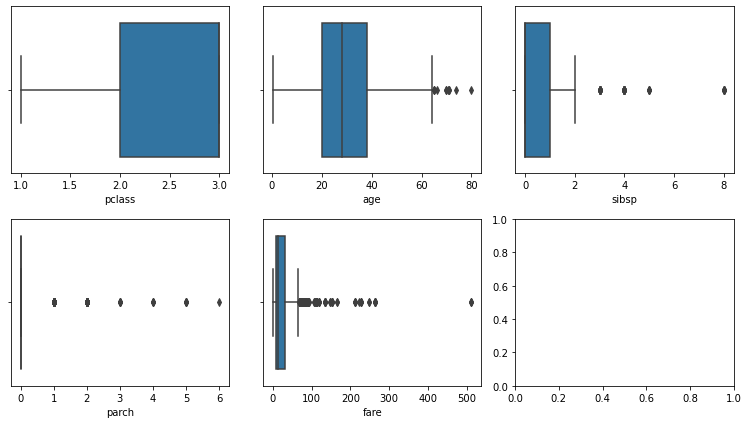

In [116]:
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    sns.boxplot(x=feat, data=df.to_pandas(), ax=axes[row_col])
    axes[row_col].set_xlabel(feat)

plt.tight_layout()

fare,ageに外れ値はそこそこあるが、今回はそのまま扱う。

### - One-hot encodingの場合

In [315]:
# 特徴量からsurvived,aliveは落とす。
X = df.drop(['survived', 'alive']).to_pandas()
y = df['survived'].to_pandas()

# cvインスタンスを生成。5 fold × 3で評価する。
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

# LightGBM用のパラメタ指定
params = {
          'objective': 'binary',  # 最小化させるべき損失関数
          'num_class': 1,       # 2値分類の場合1をセットすること  
          'metric': 'binary_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
          'learning_rate': 0.01,
          'max_depth': 5,
          'random_state': 0,  # 乱数シード
          'boosting_type': 'goss',  # boosting_type
          'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
         }

In [311]:
# もちろん、カテゴリ変数の欠損値補完をしてからOne-Hot Encoding
pipeline_for_cat = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='most_frequent')), 
                                   ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False))])

preprocess_ct = ColumnTransformer([('impute_num',SimpleImputer(strategy='median'), num_feat),
                                   ('impute_cat+dummies',pipeline_for_cat, cat_feat)],remainder='passthrough')

仮にColumnTransformerで一部のカラムしか処理対象に指定しなかった場合、デフォルトではそれらは落とされてしまうので、  
処理対象でないカラムもそのまま残したい場合はremainder='passthrough'を指定する。

In [312]:
# LightGBMのCVを回す自作クラスを呼び出す。
scores_one_hot = lightGBM_classifier_cv_func(X, y, cv=cv, ct=preprocess_ct, params=params, score_metric='accuracy')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.378304
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.460353
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.392363
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.418208
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.425687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.459853
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.418492
Training until validation scores don't im

In [313]:
scores_one_hot

[0.8547486033519553,
 0.797752808988764,
 0.8202247191011236,
 0.8146067415730337,
 0.8089887640449438,
 0.8100558659217877,
 0.8370786516853933,
 0.8764044943820225,
 0.7752808988764045,
 0.8314606741573034,
 0.8324022346368715,
 0.848314606741573,
 0.8089887640449438,
 0.8146067415730337,
 0.8314606741573034]

In [340]:
# 平均評価スコアの表示、格納
score_average_each_cases = {}
score_average_each_cases['One-Hot_Encoding'] = {'mean':np.mean(scores_one_hot), 'median':np.median(scores_one_hot)}
score_average_each_cases

{'One-Hot_Encoding': {'mean': 0.8241583495490973,
  'median': 0.8202247191011236}}

### - Target Encodingの場合

In [302]:
# 特徴量からsurvived,aliveは落とす。
X = df.drop(['survived', 'alive']).to_pandas()
y = df['survived'].to_pandas()

# cvインスタンスを生成。5 fold × 3で評価する。
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

# LightGBM用のパラメタ指定
params = {
          'objective': 'binary',  # 最小化させるべき損失関数
          'num_class': 1,       # 2値分類の場合1をセットすること  
          'metric': 'binary_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
          'learning_rate': 0.01,
          'max_depth': 5,
          'random_state': 0,  # 乱数シード
          'boosting_type': 'goss',  # boosting_type
          'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
         }

In [303]:
# もちろん、カテゴリ変数の欠損値補完をしてからTarget Encoding(Target Statistics)
pipeline_for_cat_ts = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='most_frequent')), 
                                   ('target_encoding', TargetEncoder())])

preprocess_ct_ts = ColumnTransformer([('impute_num',SimpleImputer(strategy='median'), num_feat),
                                   ('impute_cat+TS',pipeline_for_cat_ts, cat_feat)])

In [304]:
preprocess_ct_ts.set_output(transform='pandas')
ct_test = preprocess_ct_ts.fit_transform(X, y)
ct_test

,impute_num__pclass,impute_num__age,impute_num__sibsp,impute_num__parch,impute_num__fare,impute_cat+TS__sex,impute_cat+TS__embarked,impute_cat+TS__class,impute_cat+TS__who,impute_cat+TS__adult_male,impute_cat+TS__deck,impute_cat+TS__embark_town,impute_cat+TS__alone
0,3.0,22.0,1.0,0.0,7.2500,0.188908,0.336957,0.242363,0.163873,0.163873,0.322624,0.336957,0.505650
1,1.0,38.0,1.0,0.0,71.2833,0.742038,0.553571,0.629630,0.756458,0.717514,0.322624,0.553571,0.505650
2,3.0,26.0,0.0,0.0,7.9250,0.742038,0.336957,0.242363,0.756458,0.717514,0.322624,0.336957,0.303538
3,1.0,35.0,1.0,0.0,53.1000,0.742038,0.336957,0.629630,0.756458,0.717514,0.322624,0.336957,0.505650
4,3.0,35.0,0.0,0.0,8.0500,0.188908,0.336957,0.242363,0.163873,0.163873,0.322624,0.336957,0.303538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0000,0.188908,0.336957,0.472826,0.163873,0.163873,0.322624,0.336957,0.303538
887,1.0,19.0,0.0,0.0,30.0000,0.742038,0.336957,0.629630,0.756458,0.717514,0.721957,0.336957,0.303538
888,3.0,28.0,1.0,2.0,23.4500,0.742038,0.336957,0.242363,0.756458,0.717514,0.322624,0.336957,0.505650
889,1.0,26.0,0.0,0.0,30.0000,0.188908,0.553571,0.629630,0.163873,0.163873,0.322624,0.553571,0.303538


In [276]:
ct_test.isna().sum()

impute_num__pclass            0
impute_num__age               0
impute_num__sibsp             0
impute_num__parch             0
impute_num__fare              0
impute_cat+TS__sex            0
impute_cat+TS__embarked       0
impute_cat+TS__class          0
impute_cat+TS__who            0
impute_cat+TS__adult_male     0
impute_cat+TS__deck           0
impute_cat+TS__embark_town    0
impute_cat+TS__alone          0
dtype: int64

確かに欠損値が埋められ、Target Encodingされている模様。  
上記ではset_outputをしているので、Pandasで見えているが、つけない場合はnumpyで返される。  

In [305]:
# LightGBMのCVを回す自作クラスを呼び出す。
scores_ts = lightGBM_classifier_cv_func(X, y, cv=cv, ct=preprocess_ct_ts, params=params, score_metric='accuracy')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.370801
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.457871
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.388603
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.415472
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.424473
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.455608
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.418622
Training until validation scores don't im

In [306]:
scores_ts

[0.8659217877094972,
 0.797752808988764,
 0.8146067415730337,
 0.8089887640449438,
 0.8426966292134831,
 0.7988826815642458,
 0.8258426966292135,
 0.8764044943820225,
 0.7865168539325843,
 0.8314606741573034,
 0.8435754189944135,
 0.848314606741573,
 0.8146067415730337,
 0.8146067415730337,
 0.8202247191011236]

In [341]:
# 評価スコアの平均値・中央値の表示、格納
score_average_each_cases['Target_Encoding'] = {'mean': np.mean(scores_ts), 'median':np.median(scores_ts)}
score_average_each_cases
# print(f"Average Accuracy: {np.mean(scores_ts):.4f}")
# print(f"Median of Accuracy: {np.median(scores_ts):.4f}")

{'One-Hot_Encoding': {'mean': 0.8241583495490973,
  'median': 0.8202247191011236},
 'Target_Encoding': {'mean': 0.8260268240118847, 'median': 0.8202247191011236}}

([<matplotlib.axis.XTick at 0x7f238b778df0>,
 [Text(0, 0, 'One-Hot_Encoding'), Text(1, 0, 'Target Encoding')])

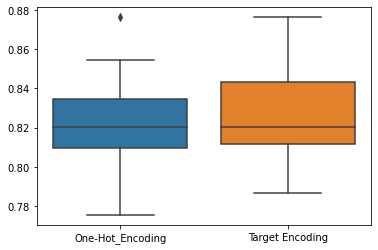

In [339]:
sns.boxplot(data=[scores_one_hot, scores_ts])
plt.xticks([0,1], ['One-Hot_Encoding', 'Target Encoding'])

両者のaccuracyを比較すると、中央値は同じで、平均はTarget_Encodingの方が高くなった。  
Target_Encodingは上方向に分散が大きく、One-Hotよりも高めに出る部分が大きいという結果になった。